### 06. 미니배치와 데이터로드

선형회귀에 한정되는 내용은 아니고, 데이터를 로드하는 방법과 미니 배치 경사 하강법에 대해서 공부!

#### 1. 미니배치와 배치크기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

- 위 데이터의 샘플 개수는 5개로 전체 데이터를 하나의 행렬로 선언하여 전체 데이터에 대해서 경사 하강법을 수행하여 학습할 수 있다.
    - 그런데 위 데이터는 현업에서 다루게 되는 방대한 양의 데이터에 비하면 굉장히 적은 양 !
    - 만약, 데이터가 수십만개 이상이라면 전체 데이터에 대해서 경사 하강법을 수행하는 것은 매우 느릴 뿐만 아니라 많은 계산량이 필요 & 메모리의 한계로 계산이 불가능할 지도 !
- 이렇게 해서 전체 데이터를 더 적은 단위로 나누어서 해당 단위로 학습하는 개념 : 미니 배치
    - 미니 배치 학습을 하게되면 미니 배치만큼만 가져가서 미니 배치에 대한 비용(cost)를 계산하고 경사 하강법을 수행
    - 그리고 다음 미니 배치를 가져가서 경사하강법을 수행하고 마지막 미니배치까지 반복
    - 이렇게 전체 데이터에 대한 학습이 1회 끝나면 1 에포크가 끝나게 된다.

- 에포크 : 전체 훈련 데이터가 한 번 사용된 주기
    - 미니 배치 학습에서는 미니 배치의 개수만큼 경사 하강법을 수행해야 전체 데이터가 한 번 전부 사용되어 1에포크가 된다.
    - 미니 배치의 개수는 결국 미니 배치의 크기를 몇으로 하느냐에 따라서 달라지는데 미니 배치의 크기를 배치크기라고 한다.
- 배치 경사 하강법 
    - 전체 데이터데 대해서 한번에 경사 하강법을 수행하는 방법 
    - 전체 데이터를 사용하므로 가중치 값이 최적값에 수렴하는 과정이 매우 안정
    - 계산량이 너무 많다.
- 미니 배치 경사 하강법 
    - 미니 배치 단위로 경사 하강법을 수행하는 방법
    - 전체 데이터의 일부만을 보고 수행하므로 최적값으로 수렴하는 과정에서 조금 헤맨다.
    - 훈련 속도가 빠르다
- 배치 크기는 보통 2의 제곱수를 사용(ex. 2, 4, 8, 16, 32, 64, ..)
    - 이유 : CPU와 GPU의 메모리가 2의 배수이므로 배치크기가 2의 제곱수일 경우 데이터 송수신의 효율을 높일 수 있음 !

-----------------------------------------------------------------------------------------------------------

#### 2. 이터레이션(Iteration)

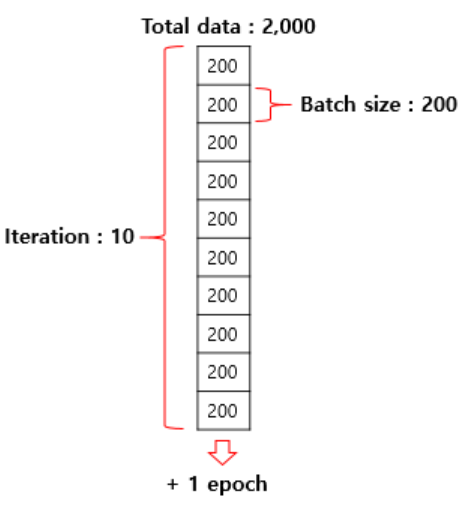

In [19]:
from IPython.display import Image
Image("/home/ubuntu/nozzi/pytorch_ex/개념/03. Linear Regression/iteration.PNG")

[위의 그림은 에포크와 배치 크기와 이터레이션의 관계]
- 이터레이션 : 한 번의 에포크 내에서 이루어지는 매개변수인 가중치 W와 b의 업데이트 횟수
- 전체 데이터가 2000일 때 배치크기를 200으로 한다면 이터레이션의 수는 총 10개로 이는 한번의 에포크 당 매개변수 업데이트가 10번 이루어짐을 의미

--------------------------------------------------------------------------------------------------------------

#### 3. 데이터 로드하기
- 파이토치에는 데이터를 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 데이터셋(Dataset)과 데이터로더(DataLoader)를 제공
- 이를 사용하면 **미니배치학습, 데이터 셔플, 병렬 처리**까지 간단히 수행할 수 있다.


Dataset을 커스텀하여 만들 수도 있지만 여기서는 텐서를 입력받아 Dataset의 형태로 변환해주는 TensorDataset을 사용 !!

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [22]:
# TensorDataset은 기본적으로 텐서를 입력으로 받는다.
# 텐서 형태로 데이터를 정의
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

In [23]:
# 이것을 TensorDataset의 입력으로 사용하여 dataset으로 저장
dataset = TensorDataset(x_train, y_train)

- 파이토치의 데이터셋을 만들었다면 데이터로더 사용 가능
- 데이터로더 : 기본적으로 2개의 인자를 입력받는다.
    - 데이터셋
    - 미니 배치의 크기 : 통상적으로 2의 배수를 사용 (ex.64, 128, 256)
    - 추가적으로 shuffle도 많이 사용 : shuffle=True -> Epoch마다 데이터 셋을 섞어서 데이터가 학습되는 순서를 바꾼다.
        - 사람도 같은 문제지를 계속 풀면 어느 순간 문제의 순서에 익숙해져 문제 자체보단 순서에 익숙해 질수 있다.
        - 문제지를 풀 때마다 문제 순서를 랜덤으로 바꾸면 도움이 되는 것처럼 모델이 데이터셋의 순서에 익숙해지는 것을 ㅂ아지하여 학습할 때는 이 옵션을 True로 주는 것을 권장

In [36]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
len(dataloader)

3

In [29]:
model = nn.Linear(3,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

In [38]:
nb_epochs = 20
for epoch in range(nb_epochs+1) : 
    for batch_idx, samples in enumerate(dataloader) : 
        print(batch_idx)
        print(samples)
        x_train, y_train = samples
        
        # H(x) 
        prediction = model(x_train)
        
        # cost
        cost = F.mse_loss(prediction, y_train)
        
        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, batch_idx+1, len(dataloader), cost.item()
        ))

0
[tensor([[89., 91., 90.],
        [73., 80., 75.]]), tensor([[180.],
        [152.]])]
Epoch    0/20 Batch 1/3 Cost: 0.166397
1
[tensor([[ 96.,  98., 100.],
        [ 73.,  66.,  70.]]), tensor([[196.],
        [142.]])]
Epoch    0/20 Batch 2/3 Cost: 1.079931
2
[tensor([[93., 88., 93.]]), tensor([[185.]])]
Epoch    0/20 Batch 3/3 Cost: 0.828134
0
[tensor([[89., 91., 90.],
        [73., 66., 70.]]), tensor([[180.],
        [142.]])]
Epoch    1/20 Batch 1/3 Cost: 0.808396
1
[tensor([[ 73.,  80.,  75.],
        [ 96.,  98., 100.]]), tensor([[152.],
        [196.]])]
Epoch    1/20 Batch 2/3 Cost: 0.612578
2
[tensor([[93., 88., 93.]]), tensor([[185.]])]
Epoch    1/20 Batch 3/3 Cost: 0.608231
0
[tensor([[ 96.,  98., 100.],
        [ 93.,  88.,  93.]]), tensor([[196.],
        [185.]])]
Epoch    2/20 Batch 1/3 Cost: 0.812020
1
[tensor([[89., 91., 90.],
        [73., 66., 70.]]), tensor([[180.],
        [142.]])]
Epoch    2/20 Batch 2/3 Cost: 0.805088
2
[tensor([[73., 80., 75.]]), tensor([[1

In [41]:
# 예측
# 임의의 입력 선언
new_var = torch.FloatTensor([[73, 80, 75]])
# 입력한 값에 대해서 예측값 y를 리턴받아 pred_y에 저장
pred_y = model(new_var)
print("훈련 후 입려기 73, 80, 75일 때의 예측값 : ", pred_y)

훈련 후 입려기 73, 80, 75일 때의 예측값 :  tensor([[152.0022]], grad_fn=<AddmmBackward>)
